In [1]:
import os
import sys
import functools

current_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(current_path)

if module_path not in sys.path:
    sys.path.append(module_path)

import xlumina.vectorized_optics as vo
import xlumina.wave_optics as so
import xlumina.optical_elements as oe
from xlumina import cm, mm, nm, um
import jax
import xlumina.toolbox as tb
import jax.numpy as jnp
import optax

from gt_fourfrelaycircuit import four_f_relay_circuit, four_f_relay_circuit_scalar

In [2]:
def mse_intensity(input_light, target_light):
    num_pix = jnp.shape(input_light)[0] * jnp.shape(input_light)[1]
    i_error = jnp.sum(jnp.abs(input_light - target_light)**2) / num_pix
    return i_error

In [18]:
sensor_lateral_size = 1024  # Resolution
wavelength = 632.8*nm
x_total = 1200*um # Space dimension
x, y = tb.space(x_total, sensor_lateral_size)

jones_vector = jnp.array([1, 1])
w0 = (1200*um , 1200*um)

gb_vectorized = vo.PolarizedLightSource(x, y, wavelength)
gb_vectorized.gaussian_beam(w0=w0, jones_vector=jones_vector)

gb_scalar = so.LightSource(x, y, wavelength)
gb_scalar.gaussian_beam(w0=w0, E0=1)

filename = 'MPI_logo.png'
MPI_mask = tb.image_to_binary_mask(filename, x, y, normalize=True, invert=True, threshold=0.5)

gb_vectorized.Ex = gb_vectorized.Ex* MPI_mask
gb_vectorized.Ey = gb_vectorized.Ey* MPI_mask
gb_vectorized.Ez = gb_vectorized.Ez* MPI_mask

gb_scalar.field = gb_scalar.field#* MPI_mask


In [40]:
#target setup
focal_1 = 10*mm
focal_2 = 10*mm
d1 = 1 # cm
d2 = 2 # cm
d3 = 1 # cm

target_light_vectorized = four_f_relay_circuit(gb_vectorized, [d1, d2, d3, focal_1, focal_2])
target_light_scalar = four_f_relay_circuit_scalar(gb_scalar, [d1, d2, d3, focal_1, focal_2])
target_light_scalar = gb_scalar

Time taken to perform one VRS propagation (in seconds): 0.1689
Time taken to perform one VRS propagation (in seconds): 0.1539
Time taken to perform one VRS propagation (in seconds): 0.1363
Time taken to perform one RS propagation (in seconds): 1.8718
Time taken to perform one RS propagation (in seconds): 1.0270
Time taken to perform one RS propagation (in seconds): 1.1482


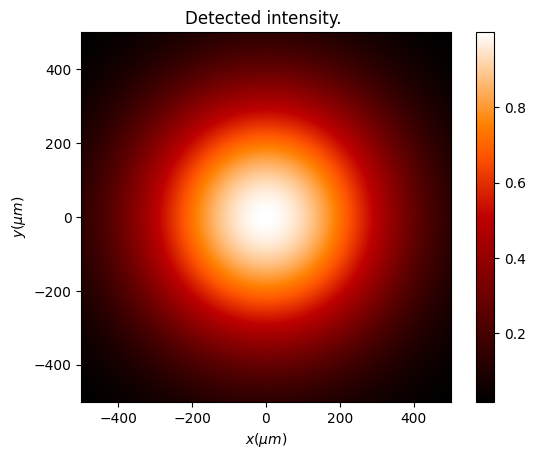

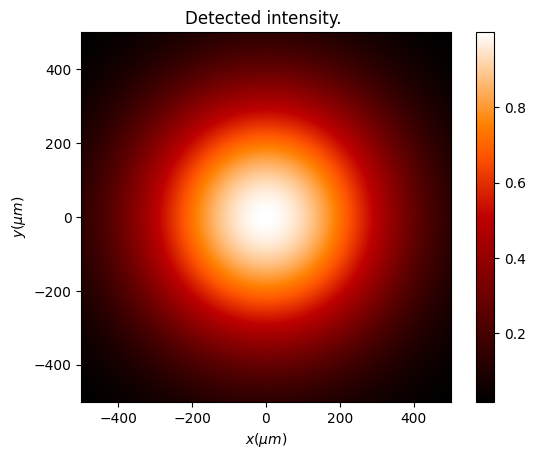

In [41]:
xlim = 500
ylim = 500

gb_scalar.draw(xlim=(-xlim, xlim), ylim=(-ylim, ylim), kind='Intensity')
target_light_scalar.draw(xlim=(-xlim, xlim), ylim=(-ylim, ylim), kind='Intensity')

In [42]:
def get_intensity(light):
    if isinstance(light, vo.VectorizedLight):
        intensity = jnp.abs(light.Ex)**2 + jnp.abs(light.Ey)**2 + jnp.abs(light.Ez)**2
    elif isinstance(light, so.ScalarLight):
        intensity = jnp.abs(light.field)**2
    return jnp.array(intensity)

target_intensity = get_intensity(target_light_scalar)

In [43]:
@functools.partial(jax.jit, static_argnums=(1,))  # Mark light (argument 1) as static
def vectorized_circuit(parameters, light):
    d_1 = 1 #parameters[0]
    d_2 = 4.5 #parameters[1]
    d_3 = parameters #parameters[2]
    f_1 = 10 #parameters[3]
    f_2 = 20 #parameters[4]

    light_stage0, _ = light.VRS_propagation(z=d_1*cm)
    modulated_lens1, _ = oe.lens(light_stage0, radius=(5/2*mm, 5/2*mm), focal=(f_1, f_1))
    light_stage1, _ = modulated_lens1.VRS_propagation(z=d_2*cm)
    modulated_lens2, _ = oe.lens(light_stage1, radius=(5/2*mm, 5/2*mm), focal=(f_2, f_2))
    detected_light, _ = modulated_lens2.VRS_propagation(z=d_3*cm)
    
    intensity = jnp.array(jnp.abs(detected_light.Ex)**2 + jnp.abs(detected_light.Ey)**2 + jnp.abs(detected_light.Ez)**2)
    return intensity

circuit_partial_vectorized = functools.partial(vectorized_circuit, light=gb_vectorized)

@functools.partial(jax.jit, static_argnums=(1,))  # Mark light (argument 1) as static
def scalar_circuit(parameters, light):
    d_1 = 1 #parameters[0]
    d_2 = 4.5 #parameters[1]
    d_3 = parameters #parameters[2]
    f_1 = 10 #parameters[3]
    f_2 = 20 #parameters[4]

    light_stage0, _ = light.RS_propagation(z=d_1*cm)
    modulated_lens1, _ = oe.lens(light_stage0, radius=(5/2*mm, 5/2*mm), focal=(f_1, f_1))
    light_stage1, _ = modulated_lens1.RS_propagation(z=d_2*cm)
    modulated_lens2, _ = oe.lens(light_stage1, radius=(5/2*mm, 5/2*mm), focal=(f_2, f_2))
    detected_light, _ = modulated_lens2.RS_propagation(z=d_3*cm)
    
    intensity = jnp.array(jnp.abs(detected_light.field)**2)
    return intensity

circuit_partial_scalar = functools.partial(scalar_circuit, light=gb_scalar)

In [44]:
@jax.jit
def loss_sophia_vectorized(parameters, target_intensity):
    input_intensity = circuit_partial_vectorized(parameters)
    mse = jnp.sum((input_intensity - target_intensity)**2) 
    return mse

@jax.jit
def loss_sophia_scalar(parameters, target_intensity):
    input_intensity = circuit_partial_scalar(parameters)
    mse = jnp.sum((input_intensity - target_intensity)**2) 
    return mse

In [45]:
def optimize_scalar(params: optax.Params, optimizer: optax.GradientTransformation, num_iterations, target_intensity) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss_sophia_scalar, allow_int=True)(params, target_intensity)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    iteration_steps=[]
    loss_list=[]

    n_best = 500
    best_loss = jnp.inf
    best_params = None
    best_step = 0
    
    print('Starting Optimization', flush=True)
    
    for step in range(num_iterations):        
        
        #input_fields, target_fields = next(dataloader)
        params, opt_state, loss_value = update(params, opt_state)
        
        print(f"Step {step}")
        print(f"Loss {loss_value}")
        print(f"Parameters {params}")
        
        iteration_steps.append(step)
        loss_list.append(loss_value)
        
        # Update the `best_loss` value:
        if loss_value < best_loss:
            # Best loss value
            best_loss = loss_value
            # Best optimized parameters
            best_params = params
            best_step = step
            print('Best loss value is updated')
            
        if step % 100 == 0:
            # Stopping criteria: if best_loss has not changed every 500 steps, stop.
            if step - best_step > n_best:
                print(f'Stopping criterion: no improvement in loss value for {n_best} steps')
                break
    
    print(f'Best loss: {best_loss} at step {best_step}')
    print(f'Best parameters: {best_params}')  
    return best_params, best_loss, iteration_steps, loss_list

In [46]:
params = jnp.array(10.0)  #(gt is 2)
optimizer = optax.adamw(learning_rate=0.5)
num_iterations = 50

parameters = optimize_scalar(params, optimizer, num_iterations, target_intensity)

Starting Optimization
Time taken to perform one RS propagation (in seconds): 0.0096
Time taken to perform one RS propagation (in seconds): 0.0072
Time taken to perform one RS propagation (in seconds): 0.0080
Step 0
Loss 203483.72554528844
Parameters 9.499500000181548
Best loss value is updated
Time taken to perform one RS propagation (in seconds): 0.0136
Time taken to perform one RS propagation (in seconds): 0.0069
Time taken to perform one RS propagation (in seconds): 0.0074
Step 1
Loss 203471.50010813403
Parameters 8.99984418144909
Best loss value is updated
Step 2
Loss 203458.66074755206
Parameters 8.510788632277622
Best loss value is updated
Step 3
Loss 203443.4543062211
Parameters 8.01643306578334
Best loss value is updated
Step 4
Loss 203426.07094575334
Parameters 7.517444209313873
Best loss value is updated
Step 5
Loss 203404.76891262352
Parameters 7.015452047252319
Best loss value is updated
Step 6
Loss 203379.974220667
Parameters 6.509232982351023
Best loss value is updated
St